In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
words = open('names.txt','r').read().splitlines()
print(f"Number of words: {len(words)} \nExamples: {words[:8]}")

Number of words: 32033 
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [237]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos,"\n",vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [238]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append to the context 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Training split 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # Validation split 10%
Xte, Yte = build_dataset(words[n2:]) # Test split 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [239]:
# For the first 5 words: 
# emma
# ... ---> e
# ..e ---> m
# .em ---> m
# emm ---> a
# mma ---> .
# olivia
# ... ---> o
# ..o ---> l
# .ol ---> i
# oli ---> v
# liv ---> i
# ivi ---> a
# via ---> .
# ava
# ... ---> a
# ..a ---> v
# .av ---> a
# ava ---> .
# isabella
# ... ---> i
# ..i ---> s
# .is ---> a
# isa ---> b
# sab ---> e
# abe ---> l
# bel ---> l
# ell ---> a
# lla ---> .
# sophia
# ... ---> s
# ..s ---> o
# .so ---> p
# sop ---> h
# oph ---> i
# phi ---> a
# hia ---> .

In [250]:
# Create the MLP 
n_embd = 10 # the dimensionality of the character embedding vectors 
n_hidden = 200 # the number of neurons in the hidden layer of the MLP 

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C : Lookup table: Example: 27 chars --> 2 dimensions
C = torch.randn((vocab_size, n_embd),             generator=g) # 10 dimensinal embeddings

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 3 x 10 inputs = 30 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # For fixing inital loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for fixing intial loss 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Number of total parameters: {sum(p.nelement() for p in parameters)}')

Number of total parameters: 11897


In [251]:
# h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 will make PyTorch infer the shape based on the other dimension
# emb.view(32,6) is the same operation as:
# 1. torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim =1)
# 2. torch.cat(torch.unbind(emb,1),dim = 1)  # INEFFICIENT: Creates new memory 
# But much faster 

In [252]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = embcat @ W1 + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
#     stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


Now, after scaling W2 and b2 appropriately, so that the loss at initialization is what we expect, the plot of the loss doesn't look like a "hockey stick" shape, because in the case of the "hockey stick" the optimzation just squashes the logits and then rearragning the logits very quickly. 

So fixing the inital loss, removes this "easy" part of the loss function where the weights are just being shrunk down.

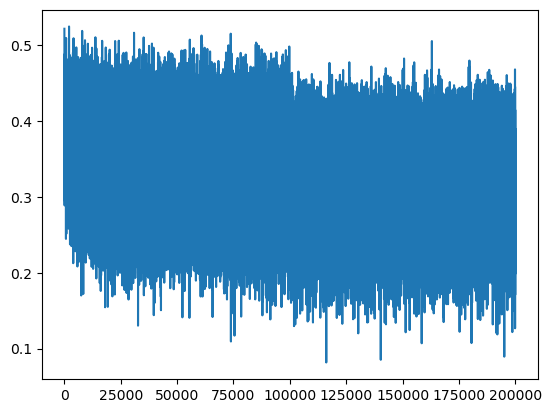

In [254]:
plt.plot(lossi)

Text(0.5, 1.0, 'tanh activation function')

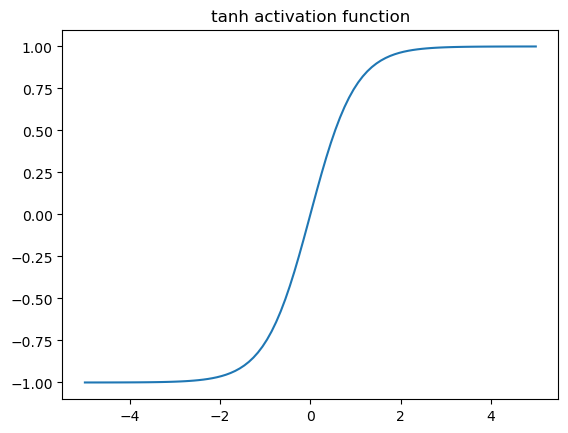

In [273]:
import numpy as np 
m = np.linspace ( - 5 , 5 , 100 )
n= torch.tanh (torch.FloatTensor (m))
plt. plot (m, n.numpy ())
plt.title("tanh activation function")

Looking at the histogram of the h (hidden layer) parameters, we see that most of the weights are -1 and 1, due to the squashing performed by the tanh function. This is not good 

Why ? 

When we perform backprop through the network, the loss propagates through all the layers, including the tanh layer. The derivative of the tanh layer (also implemented in micrograd) is along the lines of: 

(1 - t**2) * GLOBAL_GRAD ; where t is the tanh function 

So if the values are equal to either 1 or -1, the gradient will be 0, and effectively stopping the backpropagation. 


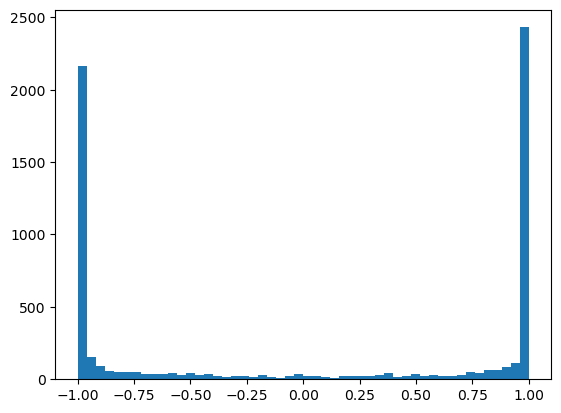

In [258]:
plt.hist(h.view(-1).tolist(), 50);

Plotting the preactivation h, shows that the values are too extreme. Resulting in a very saturated h, resulting in less training for these neurons, since they update less frequently.

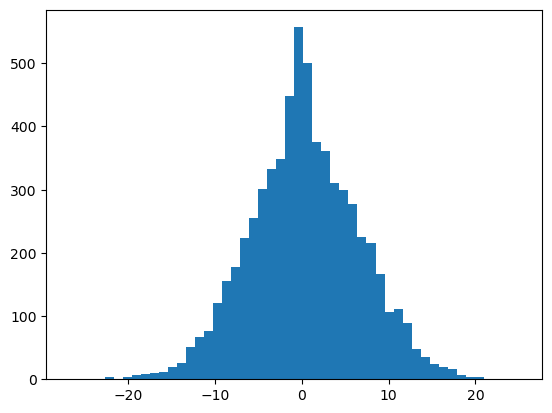

In [260]:
plt.hist(h_preact.view(-1).tolist(),50);

We can try plotting the absolute values of h, and seeing how often it is in the "flat" region of the tanh. 

White represents when it's true, black represents when it's false 

If the entire colum was white, that would be a major problem, because that would make it a "dead neuron" where no single example makes the neuron learn. 

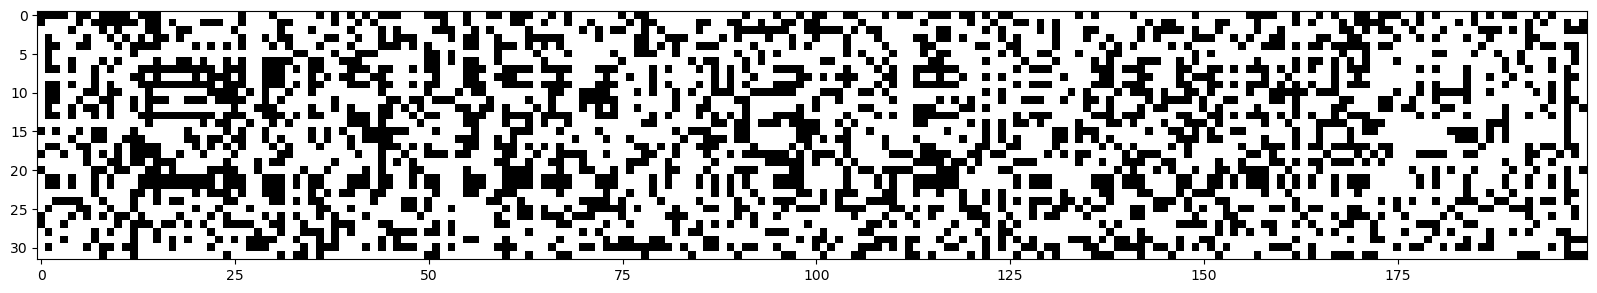

In [263]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

To fix this, h_preact is too far off from zero and that's what causing the issue. We want the h_preact to be closer to 0. We can do something very similar we did to fix the initial loss 

- Multiply the bias with a small number 
- Multiply the weights with a small number to squash them

In [255]:
@torch.no_grad() # Disable gradient tracking 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte, Yte),
    }[split]
    
    # Evaluate the model on the corresponding split
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    h = torch.tanh(embcat@W1 +b1) # N x n_hidden
    logits = h@W2 + b2 # N x vocab_size
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')


train loss: 2.0695888996124268
val loss: 2.131074905395508


Running the newer improved model: 

In [279]:
# Create the MLP 
n_embd = 10 # the dimensionality of the character embedding vectors 
n_hidden = 200 # the number of neurons in the hidden layer of the MLP 

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C : Lookup table: Example: 27 chars --> 2 dimensions
C = torch.randn((vocab_size, n_embd),             generator=g) 

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # For fixing inital loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for fixing intial loss 

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f'Number of total parameters: {sum(p.nelement() for p in parameters)}')

Number of total parameters: 11897


Just running the first batch

In [280]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = embcat @ W1 + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3135


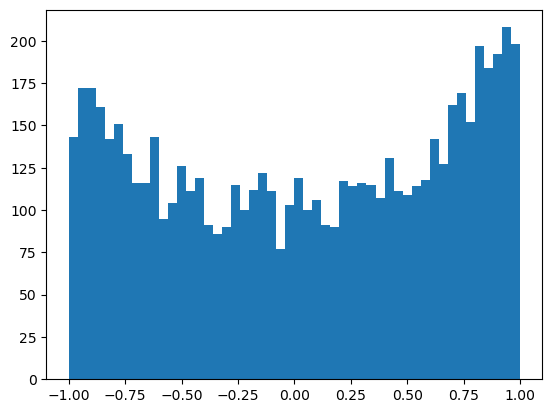

In [281]:
plt.hist(h.view(-1).tolist(), 50);

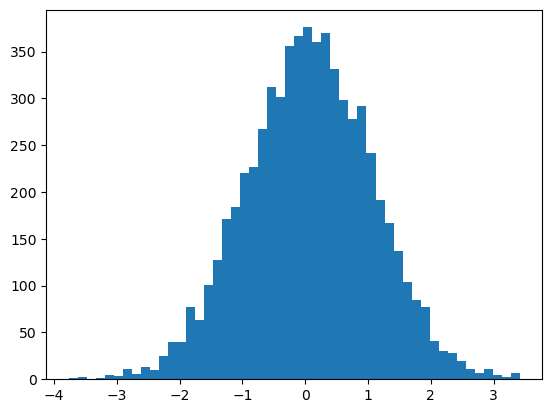

In [282]:
plt.hist(h_preact.view(-1).tolist(),50);

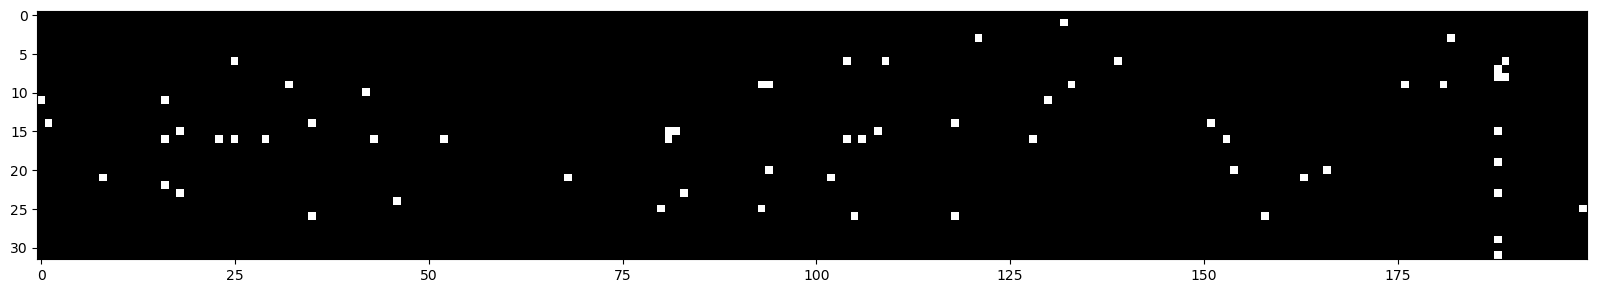

In [283]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

So, that's good - there are VERY few neurons that are saturated in either direction! 

Run for the full dataset 

In [284]:
# Optimization 
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors 
    embcat = emb.view(emb.shape[0],-1) # Concatenate the vectors 
    
    h_preact = embcat @ W1 + b1 # Hidden layer preactivation
    h = torch.tanh(h_preact) # Hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


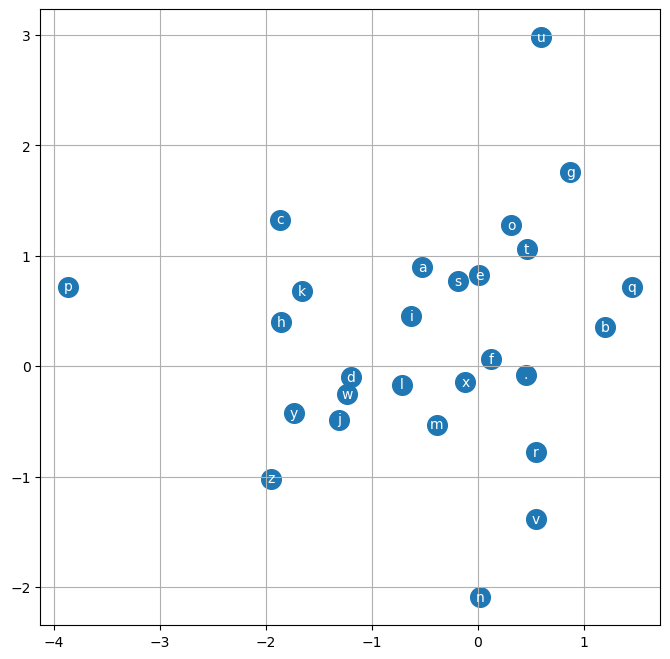

In [285]:
# Visualize the dimensions 0 and 1 of the embedding matrix
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center" , color = "white")

plt.grid('minor')

In [286]:
# Sample from the model and generate names 
g = torch.Generator().manual_seed(2147483647 + 10) 

for _ in range(20):
    
    out = []
    context = [0] * block_size # init with all "..."
    while True: 
        # forward pass the neural net 
        emb = C[torch.tensor([context])] # 1 x block_size x n_embd
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim = 1)
        ix = torch.multinomial(probs, num_samples = 1 , generator = g).item()   # sample from the distribution 
        context = context[1:] + [ix] # shift the context window and track the samples
        out.append(ix)
        # if the '.' is sampled, then finish
        if ix == 0: 
            break
     
    print("".join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [ ]:
 # 